In this notebook:

1. Multiple datasets with main tweets collected by keyword search and corresponding conversations are concatenated. 

    There are 2 datasets for the tweets downloaded by keyword search (ChatGPT). 1. data_data.json is from 30 Nov 2022 to 15 Jan 2023. 2. data_31jan_data is from 15 Jan 2023 to 31 Jan 2023.

    There are 3 datasets for converstations: 1. conv_data.json contains the conversation tweets from 30 Nov 2022 to 15 Jan 2023 which were replies to the sparking tweets that mentioned ChatGPT. 2. conv_extended_data.json has the conversation tweets from 30 Nov 2022 to 15 Jan 2023 which were a part of conversation where at least one reply mentioned ChatGPT (sparking tweets did not necessarily mention ChatGPT). 3. conv_31jan_data.json contains the conversations from 16 Jan 2023 to 31 Jan 2023.

2. Retweets in English were augmented with full text.

3. Bots detection based on the number of tweets (more than 1000) and account description.

4. Data anonymization (author_id, tweet_id and mentions are replaced with random numbers).

5. Exploratory analysis of the data:

    - Descriptive statistics for all tweets and sparking tweets only.

    - Language of tweets distribution.

    - Dynamics of the number of posts per day.

    - Dynamics of the number of unique users.

    - Geolocation of tweets.

In [5]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import json
import plotly.express as px

In [2]:
data_15jan = pd.read_json("../data/for_analysis/jsons_concatenated/data_data.json")
conv_15jan_spark = pd.read_json("../data/for_analysis/jsons_concatenated/conv_data.json")
conv_15jan_reply = pd.read_json("../data/for_analysis/jsons_concatenated/conv_extended_data.json")
data_31jan = pd.read_json('../data/for_analysis/jsons_concatenated/data_31jan_data.json')
conv_31jan = pd.read_json('../data/for_analysis/jsons_concatenated/conv_31jan_data.json')

In [3]:
def to_date(date_column,conv=False):
    if conv:
        return pd.to_datetime(date_column, utc=True).dt.date
    else:
        return pd.to_datetime(date_column).dt.date

conv = pd.concat([conv_15jan_spark,conv_15jan_reply,conv_31jan,data_31jan],axis=0)
conv=conv.reset_index(drop=True)
data = data_15jan.copy()

data['date'] = to_date(data['created_at'])
conv['date'] = to_date(conv['created_at'],conv=True)

data = pd.concat([data,conv],axis=0)
data=data.reset_index(drop=True)
conv_15jan_spark,conv_15jan_reply,conv_31jan,data_31jan,data_15jan = None,None,None,None,None

data.columns

Index(['text', 'edit_history_tweet_ids', 'referenced_tweets',
       'possibly_sensitive', 'reply_settings', 'lang', 'id', 'created_at',
       'conversation_id', 'author_id', 'public_metrics.retweet_count',
       'public_metrics.reply_count', 'public_metrics.like_count',
       'public_metrics.quote_count', 'public_metrics.impression_count',
       'entities.annotations', 'entities.mentions', 'entities.hashtags',
       'entities.urls', 'geo.place_id', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'in_reply_to_user_id',
       'attachments.media_keys', 'entities.cashtags', 'attachments.poll_ids',
       'withheld.copyright', 'withheld.country_codes', 'withheld.scope',
       'date'],
      dtype='object')

### 1. Handling retweets

In [4]:
retweets = data.loc[(data.text.str.startswith("RT ")) & (~data.referenced_tweets.isnull())].copy()
originals = data.loc[(~data.text.str.startswith("RT ")) | (data.referenced_tweets.isnull()),["id","text"]].copy()
originals = originals.set_index("id")

In [5]:
originals = originals.to_dict()['text']
len(originals.keys())

14931090

In [6]:
text_rt = []
not_found = []
repl_retw = []

for r in retweets["referenced_tweets"]:
    if len(r)==1:
        try:
            text_rt.append(originals[int(r[0]['id'])])
            repl_retw.append(r[0]['type'])
            not_found.append(None)
        except:
            text_rt.append(None)
            repl_retw.append(r[0]['type'])
            not_found.append(int(r[0]['id']))
    else:
        try:
            text_rt.append(originals[int(r[0]['id'])])
            repl_retw.append(r[0]['type'])
            not_found.append(None)
        except:
            text_rt.append(None)
            repl_retw.append(r[0]['type'])
            not_found.append(int(r[0]['id']))        

In [7]:
retweets["text_rt"] = text_rt 
retweets["repl_retw"] = repl_retw
retweets["not_found"] = not_found 

In [8]:
sum(~retweets.not_found.isnull())

1095985

In [9]:
# Tweets in ENGLISH only
missing = retweets.loc[(~retweets["not_found"].isnull()) & (retweets["lang"]=="en"), "not_found"].to_list()
print(len(missing))
missing = set(missing)
print(len(missing))
with open("../data/missing_retweets.txt","w") as f:
    for tweet_id in missing:
        f.write(str(int(tweet_id)))
        f.write("\n")

769183
70103


In [10]:
with open("../data/missing_retweets.txt","r") as f:
    missing = f.readlines()
missing = [int(k.rstrip('\n')) for k in missing]
len(missing)

70103

In [12]:
retweets = retweets.drop("repl_retw",axis=1)

### 2. Data augmentation with missing tweets

In [27]:
from tqdm import tqdm
path='../data/missing_tweets/'
files = os.listdir(path)

count=0
for file in tqdm(files):
    with open(path+file, 'r',encoding="utf-8") as f:
        temp = json.load(f)
        if count==0:
            mis = pd.json_normalize(temp)
            count+=1
        else:
            df = pd.json_normalize(temp)
            mis = pd.concat([mis,df],axis=0)
mis = mis.reset_index(drop=True)
mis.to_json("../data/for_analysis/missing_retweets.json")

100%|██████████| 24458/24458 [3:32:54<00:00,  1.91it/s]  


In [15]:
mis = pd.read_json("../data/for_analysis/missing_retweets.json")
mis = mis.loc[:,["id","text"]]
mis.columns = ["id","text_rt"]
mis.id = mis.id.astype('int64')

originals = data.loc[(~data.text.str.startswith("RT ")) | (data.referenced_tweets.isnull())].copy()
originals["text_rt"] = originals["text"]
originals["not_found"] = -1

retweets.loc[retweets.not_found.isnull(),"not_found"] = -1
retweets.not_found = retweets.not_found.astype('int64')

retweets_not_found = retweets.loc[retweets.not_found != -1].copy()
retweets_found = retweets.loc[retweets.not_found == -1].copy()

In [16]:
merged = pd.merge(retweets_not_found, mis, left_on = "not_found", right_on ="id", how="left")

In [17]:
merged["text_rt"] = merged["text_rt_y"]
merged["id"] = merged["id_x"]
merged=merged.drop(["id_x","id_y","text_rt_y","text_rt_x"],axis=1)
sum(~merged["text_rt"].isnull())

104329

In [18]:
sum(merged["text_rt"].isnull())

991656

In [19]:
retweets_augm = pd.concat([retweets_found,merged],axis=0)
retweets_augm.shape[0] == retweets.shape[0]

True

In [20]:
data_augm = pd.concat([originals, retweets],axis=0)
data.shape[0] == data_augm.shape[0]

True

In [21]:
sum(data_augm.text_rt.isnull())

1095985

In [67]:
data_augm = data_augm.reset_index(drop=True)
data_augm.to_pickle("../data/for_analysis/data_augm.pkl")

### 1. Bot Detection

In [6]:
data = pd.read_pickle("../data/for_analysis/data_augm.pkl")
print(data.shape)
data = data.drop_duplicates(subset=['text','id'])
data = data.reset_index(drop=True)
data.shape

(16978909, 32)


(16830997, 32)

In [7]:
len(data.author_id.unique())

5541457

In [8]:
authors_eng = data.loc[data.lang=="en","author_id"].unique()
len(authors_eng)

3850475

In [9]:
data['total']=1
potential_bots = data.loc[:,["author_id","total"]].groupby("author_id").sum()
potential_bots.sort_values("total",ascending=False).head(20)

,total
author_id,
1316495843621511168,9331
1458788154106912768,9246
1356588046616043520,5533
895814938995957760,4330
1167839853184258048,2453
19519463,2417
920321515077414912,2338
1575684749523197952,2313
1506967793409064960,2068


<Axes: >

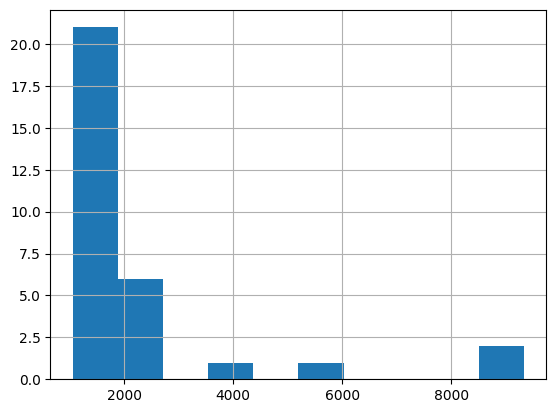

In [10]:
potential_bots.loc[potential_bots.total>1000].total.hist()

In [11]:
author_ids = potential_bots.loc[potential_bots.total>10].index.to_list()
print("Number of accounts that tweeted more than 10 tweets: ", len(author_ids))

with open("../data/potential_bots.txt","w") as f:
    for author_id in author_ids:
        f.write(str(int(author_id)))
        f.write("\n")

Number of accounts that tweeted more than 10 tweets:  257858


In [3]:
from tqdm import tqdm
path='../data/potential_bots/'
files = os.listdir(path)

count=0
for file in tqdm(files):
    with open(path+file, 'r',encoding="utf-8") as f:
        temp = json.load(f)
        if count==0:
            users = pd.json_normalize(temp)
            count+=1
        else:
            df = pd.json_normalize(temp)
            users = pd.concat([users,df],axis=0)
users = users.reset_index(drop=True)
users.to_json("../data/for_analysis/users.json")

100%|██████████| 1497/1497 [27:55<00:00,  1.12s/it]


In [6]:
users.shape

(101276, 139)

In [12]:
users = pd.read_json("../data/for_analysis/users.json")
users["bot"] = [re.findall(r"(?<![a-zA-Z])bot\W",descr.lower()) for descr in users.description]
users["bot"] = [1 if lst else 0 for lst in users["bot"]]
sum(users.bot==1)

247

In [13]:
users["app"] = [re.findall(r"app(?=[^a-zA-Z])",scr.lower()) for scr in users.screen_name]
users["app"] = [1 if lst else 0 for lst in users["app"]]
sum(users["app"]==1)

7

In [14]:
users["bot"] = 1*((users["bot"] + users["app"])>0)
sum(users["bot"]==1)

254

In [15]:
bots = users.loc[users["bot"]==1]
#bots.to_json("../data/for_analysis/bots.json")

In [16]:
bots_active = potential_bots.loc[potential_bots.total>1000].index.to_list()
len(bots_active)

31

In [17]:
bots = set(bots_active+users.loc[users["bot"]==1,"id"].to_list())
len(bots)

283

### 2. Anonymization

In [19]:
data["total"]=1
print("The number of tweets: ", data.shape[0])
print("The number of unique users: ", len(data.author_id.unique()))
print("The number of conversation ids: ", sum(data.conversation_id.value_counts()>0))

The number of tweets:  16830997
The number of unique users:  5541457
The number of conversation ids:  2889276


In [30]:
# 1.1. Twitter-assigned tweet, user, and conversation identifiers with random, numeric, and anonymous identifiers.
ids_tweets = set(data['id'].to_list()+data["conversation_id"].to_list())
ids_authors = set(data['author_id'].to_list())

replace_tweets = dict(zip(ids_tweets,range(len(ids_tweets))))
replace_authors = dict(zip(ids_authors,range(len(ids_authors))))

data['author_id_real'] = data['author_id']
data['id_real'] = data['id']
data["conversation_id_real"] = data['conversation_id']


data['author_id'] = [replace_authors[i] for i in data['author_id']]
data['id'] = [replace_tweets[i] for i in data['id']]
data["conversation_id"] = [replace_tweets[i] for i in data['conversation_id']]

In [30]:
sum(data['text_rt'].isnull())

1095983

In [31]:
sum(~data.text_rt.isnull())

15735014

In [32]:
data['text_rt'] = data['text_rt'].fillna("")
data['text'] = data['text'].fillna("")

In [ ]:
# 1.2. Replaced email addresses and phone numbers with placeholders (e.g., <tel> for telephone numbers). 
def replace_email_phone_links(text):
    text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', "<email>", text)
    text = re.sub('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})',"<tel>",text)
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', "<link>", text)
    return text


data['text_rt'] = [replace_email_phone_links(t) for t in data['text_rt']]
data['text'] = [replace_email_phone_links(t) for t in data['text']]

In [ ]:
sum(data['text_rt'].str.contains("<tel>"))

387434

In [ ]:
sum(data['text_rt'].str.contains("<email>"))

4144

In [ ]:
sum(data['text_rt'].str.contains("<link>"))

3056150

In [ ]:
# 1.3. Replaced all mentions of usernames in tweets with their new anonymous user identifier (e.g., “@18415125”). 
unique_mentions = [re.findall(r'@\S+', text) for text in data.text.to_list() + data.text_rt.to_list()]
unique_mentions = set([m for ml in unique_mentions for m in ml])
replacement = ["anon"+str(i) for i in range(len(unique_mentions))]
replace_authors_name = dict(zip(unique_mentions, replacement))

In [ ]:
def replace_authors(text):
    mentions = re.findall(r'@\S+', text)
    if mentions:
        for mention in mentions:
            text = text.replace(mention,replace_authors_name[mention])
        return text
    else:
        return text

data['text'] = [replace_authors(t) for t in data['text']]
print("text is finished")
data['text_rt'] = [replace_authors(t) for t in data['text_rt']]

text is finished


In [ ]:
data.text

0           Does anyone who is using ChatGPT either native...
1           What exactly is ChatGPT? Is it the tech world’...
2           anon1345445 Maybe some more PR is necessary. R...
3           ChatGPT: qué es, cómo usarlo y qué puedes hace...
4           anon1051389 Anyone got any kind words for the ...
                                  ...                        
16830992    RT anon1094219 I've probably been the only per...
16830993    RT anon919373 Everyone is talking about ChatGP...
16830994    RT anon28316 ChatGPT isn’t the only AI-powered...
16830995    RT anon1032846 Voilà : premier gros soupçon d'...
16830996    RT anon28316 ChatGPT isn’t the only AI-powered...
Name: text, Length: 16830997, dtype: object

In [31]:
bot_fake_ids = set(data.loc[data.author_id_real.isin(bots),"author_id"].to_list())
with open("../data/for_analysis/bot_fake_ids.txt","w") as f:
    for i in bot_fake_ids:
          f.write(str(i)+"\n")

In [32]:
len(data.loc[data.author_id_real.isin(bots),"author_id"])

80389

In [15]:
data.to_pickle("../data/for_analysis/data0.pkl")

### Exploratory analysis

In [36]:
data = pd.read_pickle("../data/for_analysis/data0.pkl")

 Median, mean, SD, quartiles of likes, replies, retweets, etc. of sparking tweets (i.e., first tweet in conversation or Median, mean, SD, halflife of lengths of conversations etc. Just to get an idea of our data.

In [ ]:
pub_metrics = data.loc[:,["public_metrics.retweet_count","public_metrics.reply_count","public_metrics.like_count",
                        "public_metrics.quote_count"]]
print(pub_metrics.shape[0])                       
round(pub_metrics.describe().iloc[1:,:],3)

16830997


,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
mean,228.846,0.390,4.546,0.036
std,1683.774,13.726,235.851,3.440
min,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000
75%,0.000,0.000,1.000,0.000
max,35579.000,17185.000,176848.000,4612.000


In [ ]:
data.loc[:,["public_metrics.retweet_count","public_metrics.reply_count","public_metrics.like_count",
                        "public_metrics.quote_count"]].median(axis=0)

public_metrics.retweet_count    0.0
public_metrics.reply_count      0.0
public_metrics.like_count       0.0
public_metrics.quote_count      0.0
dtype: float64

In [ ]:
sparking_tweets = data.groupby(["conversation_id"])["author_id"].count()
print(sum(sparking_tweets>1))
sparking_tweets = sparking_tweets[sparking_tweets>1].index.to_list()

192240


In [ ]:
#sparking = data.loc[(data.id == data.conversation_id) & (data['public_metrics.reply_count']>0)]
#sparking_tweets = sparking.groupby("conversation_id")["author_id"]
sparking = data.loc[data.conversation_id.isin(sparking_tweets)]
sparking = sparking.loc[(sparking.id == sparking.conversation_id)]
sparking = sparking.loc[:,["public_metrics.retweet_count","public_metrics.reply_count","public_metrics.like_count",
                        "public_metrics.quote_count"]]
print(sparking.shape)
round(sparking.describe(),3)

(127749, 4)


,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
count,127749.000,127749.000,127749.000,127749.000
mean,14.871,6.463,75.480,1.679
std,249.189,99.015,963.151,27.291
min,0.000,0.000,0.000,0.000
25%,0.000,1.000,1.000,0.000
50%,0.000,1.000,4.000,0.000
75%,2.000,3.000,16.000,0.000
max,35570.000,17185.000,159790.000,4612.000


In [ ]:
sparking.median(axis=0)

public_metrics.retweet_count    0.0
public_metrics.reply_count      1.0
public_metrics.like_count       4.0
public_metrics.quote_count      0.0
dtype: float64

In [ ]:
data["total"] = 1
tweets_day = data.loc[:,["date","total"]].groupby("date").sum().reset_index()
tweets_day.to_excel("../analysis/all_tweets_posts_dynamics.xlsx")

fig = px.line(tweets_day, x="date", y="total", title='Dynamics of the number of Tweets that mention ChatGPT and converstions',
                labels=dict(date="Date", total="Number of Tweets per day"),template="plotly_white",
                 width=800, height=600)

fig.show()

In [ ]:
data = data.sort_values("date",ascending=True)
unique_users = data.loc[:,["author_id","date"]].groupby(["author_id"]).first().reset_index()

print(unique_users.shape)
unique_users['total'] = 1
unique_users = unique_users.loc[:,["total","date"]].groupby("date").sum().reset_index()
len(data.author_id.unique())

(5541457, 2)


5541457

In [ ]:
unique_users["Line color"] = "Unique users" 
tweets_day['Line color'] = "Tweets"
df = pd.concat([unique_users,tweets_day],axis=0)
df.to_excel("../analysis/unique_users_tweets.xlsx")

In [ ]:
fig = px.line(df, x="date", y="total", title='Dynamics of the number of unique users/ Tweets',color="Line color",
                labels=dict(date="Date", total="Number of unique users/Tweets per day"),template="plotly_white",
                 width=800, height=600)

fig.show()

### Geography

In [ ]:
geo = data.loc[~data['geo.place_id'].isnull(),['created_at','id','lang','geo.place_id', 'geo.coordinates.type','geo.coordinates.coordinates']]
geo.shape

(160368, 6)

In [ ]:
place_ids = geo["geo.place_id"].unique()
len(place_ids)

17753

In [33]:
with open("../data/place_ids.txt","w") as f:
    for place_id in place_ids:
        f.write(str(place_id))
        f.write("\n")

In [7]:
from tqdm import tqdm
path='../data/geo/'
files = os.listdir(path)

count=0
for file in tqdm(files):
    with open(path+file, 'r',encoding="utf-8") as f:
        temp = json.load(f)
        if count==0:
            geo = pd.json_normalize(temp)
            count+=1
        else:
            df = pd.json_normalize(temp)
            geo = pd.concat([geo,df],axis=0)
geo = geo.reset_index(drop=True)
geo.to_json("../data/for_analysis/geo.json")

100%|██████████| 17748/17748 [10:08<00:00, 29.19it/s]


In [8]:
geo=pd.read_json("../data/for_analysis/geo.json")
geo.head()

,id,name,full_name,country,country_code,url,place_type,centroid,contained_within,polylines,...,attributes.190533:id,attributes.567718:targetable,attributes.162763:id,attributes.162772:state_id,attributes.162813:id,attributes.162772:cousub_id,attributes.random_attr,attributes.162768:id,attributes.567718:metro,attributes.162834:id
0,1f4df2b4746ddea7,Brampton,"Brampton, Ontario",Canada,CA,https://api.twitter.com/1.1/geo/id/1f4df2b4746...,city,"[-79.74353192502639, 43.725062]","[{'id': '0192e4d84ed0ea4e', 'name': 'Toronto',...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80cf9987ff7e9762,Lake Elsinore,"Lake Elsinore, CA",United States,US,https://api.twitter.com/1.1/geo/id/80cf9987ff7...,city,"[-117.34513912574008, 33.665765]","[{'id': 'e4315a8602024dcb', 'name': 'LOS ANGEL...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,018e2bf71a3ef896,Prague,"Prague, Czech Republic",Czech Republic,CZ,https://api.twitter.com/1.1/geo/id/018e2bf71a3...,city,"[14.446473098716092, 50.05957115]","[{'id': '0126ba1e341b038c', 'name': 'Prague', ...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3daa1b987e17d095,Dalton Piercy,"Dalton Piercy, England",United Kingdom,GB,https://api.twitter.com/1.1/geo/id/3daa1b987e1...,city,"[-1.2808998181629203, 54.67351755]","[{'id': '67bc7263f7b9047b', 'name': 'North Eas...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4ca13653c1a41e50,Nyköping,"Nyköping, Sverige",Sweden,SE,https://api.twitter.com/1.1/geo/id/4ca13653c1a...,city,"[16.974238986672706, 58.72823315]","[{'id': '2258e8caf1fed45f', 'name': 'Södermanl...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
geo_dict = geo.loc[:,["id","country"]].set_index("id").to_dict()
geo_subset = data.loc[~data["geo.place_id"].isnull()]
geo_subset["country"] = geo_subset["geo.place_id"].replace(geo_dict["country"])

In [16]:
pd.DataFrame(geo_subset.country.value_counts())

,country
United States,83763
United Kingdom,10333
India,8095
Canada,5571
Brazil,5292
...,...
Cook Islands,1
ac12f03bde23d3a3,1
British Indian Ocean Territory,1
South Sudan,1


In [17]:
pd.DataFrame(geo_subset.country.value_counts()).to_excel("../analysis/geo.xlsx")

### Languages

In [34]:
langs = data.loc[:,["lang","total"]].groupby("lang").sum().reset_index()
langs = langs.sort_values("total",ascending=False)
langs["total"] = round(langs["total"]/langs["total"].sum() *100,2)
langs["lang"]=langs["lang"].replace({"en":"English","ja":"Japanese","es":"Spanish","fr":"French","zh":"Chinese",
                                        "de":"German","ar":"Arabic","tr":"Turkish","ko":"Korean","pt":"Portuguese","nl":"Dutch"})

langs.to_excel("../analysis/langs_distribution.xlsx")

fig = px.bar(langs.iloc[[0,3,4,5,6,7,9,11,12,13],:], x='lang', y='total',text_auto=True,template="plotly_white",
                labels=dict(lang="Language", total="Per cent of Tweets"),
                title = "Top 10 languages")

fig.show()

In [35]:
jap = data.loc[data.lang == "ja",["date","total"]].groupby("date").sum().reset_index()
eng = data.loc[data.lang == "en",["date","total"]].groupby("date").sum().reset_index()

jap["Group"] = "Japanese" 
eng['Group'] = "English"

df = pd.concat([jap,eng],axis=0)

fig = px.line(df, x="date", y="total", title='Dynamics of the number of Tweets',color="Group",
                labels=dict(date="Date", total="Number of Tweets per day"),template="plotly_white",
                 width=800, height=600)

fig.show()